In [1]:
#|default_exp init

Background: We did start with the goal of training an autoencoder, in Notebook 8, 
and realized we don't have the tools to make this work.
So we decided to create tools that will allow us to create a good Autoencoder..
While creating the tools we're doing a fashion Mnist classifier.
We're gradually unwinding and we'll come back to creating an Autoencoder...

# Initialization

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init

#Avoiding Torcheval import issue by ignoring the first import exception and repeating
try: from torcheval.metrics import MulticlassAccuracy
except ImportError:     pass
from torcheval.metrics import MulticlassAccuracy

from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

import logging
logging.disable(logging.WARNING)

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)


set_seed(42)

We're going to try to get fashion MNIST training to accuracy of 90%+, 90% accuracy, below 10% error.. 
3-4% error is SOTA, i.e., [papers with code](https://paperswithcode.com/sota/image-classification-on-fashion-mnist).

Without using any architectural changes, no resNets, etc.

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

A simple model, first convolution is taking a 9x9 by 1 channel input.
We should compress it a bit, so we ade it 8 channels output for the convolution 
and then doubled it to 16, doubled it to 32, doubled it to 64. 
That's going to get to a 14x14 image, 7x7, 4x4, 2x2 and then 1x1.
(So we get the 10 digits.??)
No thought at all behind this architecture, just pure convolutional, 
with necessary `Flatten` to get rid of the unit axes.

In [4]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

Q: why do we double the number of filters in successive convolutions?
A: these are all stride-2 convolutions. Each stride-2 `conv()` 
is changing the grid size (e.g.,from 28 by 28 to 14 by 14) 
by a factor of 4 in total.
We want it to learn something, and if we give it exactly the same number of
units or activations it's not really forcing it to learn things as much.
Ideally, as we decrease the grid size, we want to have enough channels 
that we end up with a few less activations, but not too few. 
If we double the number of channels, (decreased the grid size by 4, increased the channel count by 2), 
overall the number of activations decreased by a factor of 2.
We want to force it to find ways of compressing the information intelligently as it goes down. 
We want to have a roughly similar amount of compute through the neural net 
so as we decrease the grid size we can add more channels.
Decreasing the grid size decreases the amount of compute.
Increasing the channels then gives it more things to compute.
So it is a compromise between the amount of compute that it's doing,
while also giving it some kind of compression work to do.

Let's do an LRfinder for this simple model.
This model is so bad that when JH used the LRfinder in the usual way 
it looked ridiculous, impossible to see what's going on...
So JH added a multiplier `gamma`.
We dialed it down to make it much more gradual, and only then manage to get the LRfinder 
to tell us anything useful.

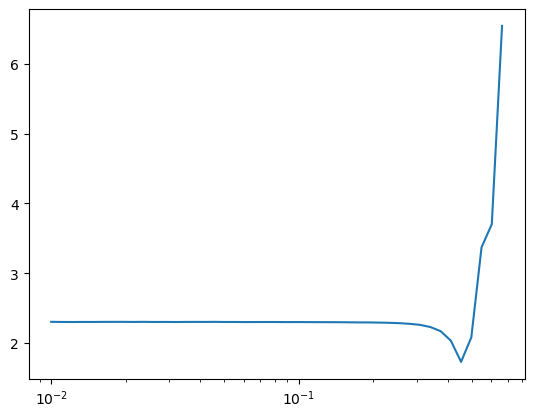

In [5]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

tried using a learning rate of 0.2 (after trying different values, .2 seems about the highest
we can get up to) 

In [7]:
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

It starts training and then we lose it.

accuracy,loss,epoch,train
0.163,2.302,0,train
0.482,1.552,0,eval


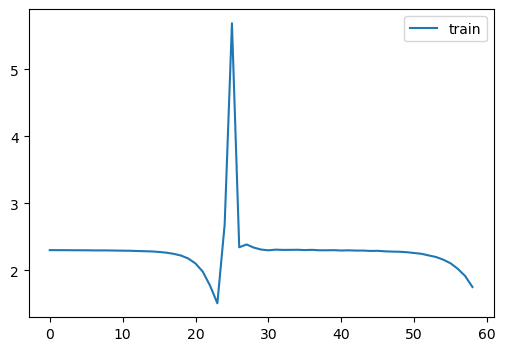

In [8]:
learn.fit(1)

In the colorful Dimension plot we get activations crashing.

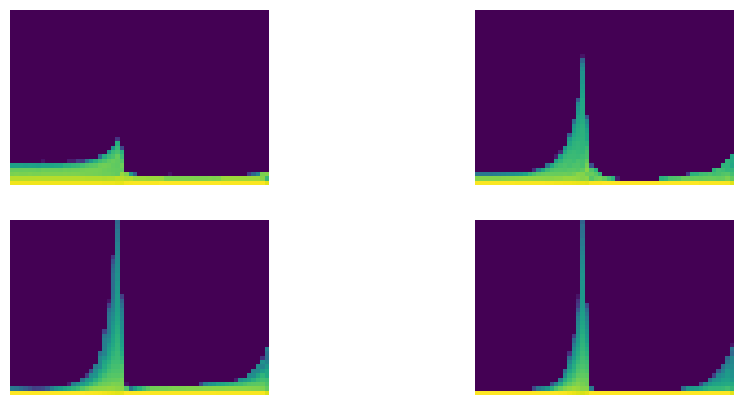

In [9]:
astats.color_dim()

And we can see in the `plot_stats()` the key problem:
We don't have zero mean standard deviation one layers at the start,
so we certainly don't keep them throughout.

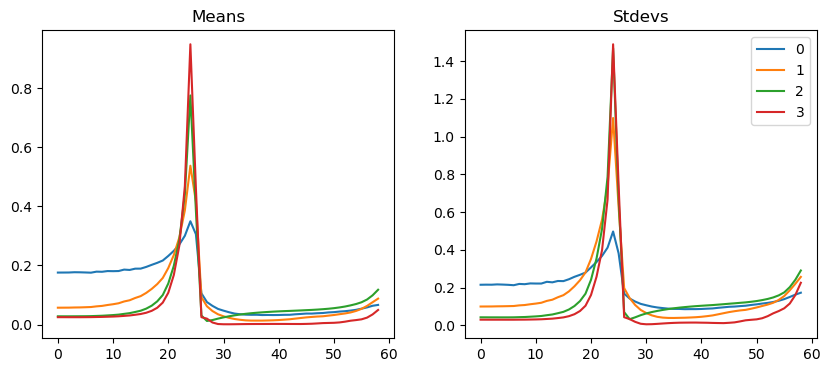

In [10]:
astats.plot_stats()

### Cleaning up GPU memory

Using Jupyter notebooks we can run out of GPU memory for many reasons:
(1) The notebook stores the results of previous cell evaluations.  
If we type `_` it returns the last thing evaluated,
and we can do more `_`s to go backwards in time.
Or we can use numbers to get the output of a cell, e.g., for `Out[16]:` use `_16`. 
If an output shown is a big CUDA tensor, Jupyter will keep that GPU memory.
So, when running out of GPU memory we can clean those `_`s.
JH found such a function in the IPython source code, 
so copied the important bits to `clean_ipython_hist()`

In [11]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

2. If we have a Cuda error or exception, then the exception object is stored by Python.
Any tensors that were allocated in that traceback will stay allocated.
JH created a clean_tb function which gets rid of that.
This is particularly problematic because if you have a Cuda out of memory error,
and then try to re-run it you'll still have a Cuda out of memory error,
as the memory that was allocated before is now in that traceback.

In [12]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

When we get a Cuda out of memory error memory we can call `clean_mem` and that will
clean the memory in our Traceback, clean the memory used in Jupiter history,
do a garbage collect, empty the Cuda cache.
That should give us a totally clean GPU, and we don't have to restart your notebook .

In [13]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

A deep Learning Net takes an input and puts it through a bunch of Matrix multiplications,
(and activation functions that don't change the argument).
Imagine we start with some 50x50 deep neural net.
A 50 deep neural net is taking the previous input and doing a
matrix multiplied by some (initially) random weights. 
If we run this, after 50 times of multiplying matrices we end up with nans.

In [14]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [15]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

Mathematically speaking these arent Nans (zeros) but really big (small) numbers
that computers can't handle as the internal representation has no ability to discriminate between them.
The way a floating point is stored, the further you get away from zero the less accurate the numbers are.
To address this problem we have to scale our weight matrices exactly right.
So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1 and the mean stays at 0.

There's a paper that describes how to do this for multiplying lots of matrices together.
They look to gradients and the propagation of gradients and they came
up with a particular weight initialization of using a uniform with 
with one over root n as the bounds of that uniform.
They studied what happened with various different activation functions.
We now have this way of initializing neural networks, 
called either Glorot or Xavier initialization.

We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). 
The right scale for a given layer is <br> $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

Here we have 100 inputs, root of 100 is 10, 1 over 10 is 0.1.
If we start with random numbers and then we multiply by random numbers
times 0.1 (Glorot initialization), we end up with numbers that are reasonable.

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[-0.81, -0.20, -0.18,  0.24, -0.47],
        [ 0.04, -0.51,  0.52,  0.15,  0.53],
        [ 0.10, -0.10, -0.35, -0.23, -0.68],
        [ 0.03,  0.11, -1.07,  0.63,  0.05],
        [-1.11, -0.25,  0.61, -0.83, -0.14]])

### Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. 
If we take a a tensor `t` and just put some values in it,
the mean is the sum divided by the count, e.g. 6.25.

In [17]:
t = torch.tensor([1.,2.,4.,18])

In [18]:
m = t.mean(); m

tensor(6.25)

We want a measure of how far away each data point is from the mean, how much variation there is.
If all the data points are very similar to each other, 
then the average distance away of each point from the mean is small.
If we had points widely spread we may have the same mean
but the distance from each point to the mean is quite a long way.
We want a measure of how far away the points are on average from the mean.

In [19]:
(t-m).mean()

tensor(0.)

We can take our tensor, subtract the mean and then take the mean of that.
because we've got some numbers that are bigger than the mean and some that are smaller than the mean.
If we average them we get zero.
So we can fix that in one of (at least) two ways:
either Square those differences and then take the square root,
or we could take the absolute differences.

In [20]:
(t-m).pow(2).mean()

tensor(47.19)

In [21]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [22]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

We can calculate variance as the mean of the square of the differences.
The mean of the squared data points minus the square of the mean of the data points 
is also the variance.
This is very helpful because it means we never have to calculate this,
you can just calculate the mean.
With just the data points on their own you can actually calculate the variance.
This is a really nice shortcut, how we normally calculate variance.

But, what's important here is that the latter is generally much easier to work with. 
We only have to track two things: the sum of the data, and the sum of squares of the data. 
In the first form we have to go thru all the data twice 
(once to calculate the mean, once to calculate the differences).

In [23]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

You can see why these are equal if you want to work thru the algebra. Or not.

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

Covariance tells us how much two things vary not just on their own but together.

Let's see that in code. So now we need two vectors. First `t`.

In [24]:
t

tensor([ 1.,  2.,  4., 18.])

and `u`  which is two times `t`  with a bit of randomness.

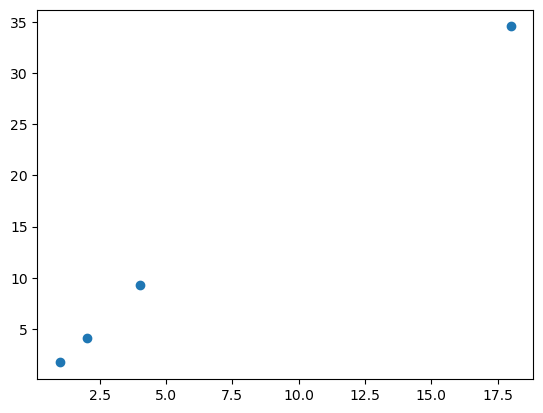

In [25]:
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

`u` and `t` are closely correlated, but not perfectly correlated.
The *covariance* tells us how they vary together and separately.

Like before each data point minus its mean, but now we have 2 different tensors, t and u.
We're going to do with `u` the other data points minus their mean and we multiply them together.
So it's actually the same thing as standard deviation, but in standard deviation it's
kind of like the covariance with itself.
That's a product we can calculate.

In [26]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 56.21,  35.17,   7.09, 260.07])

then take the mean of that to give us the covariance between those two tensors.
It is quite a high number.

In [27]:
prod.mean()

tensor(89.64)

Lets compare it to two things that aren't very related.
Let's create a totally random tensor`v`, is not related to `t`.

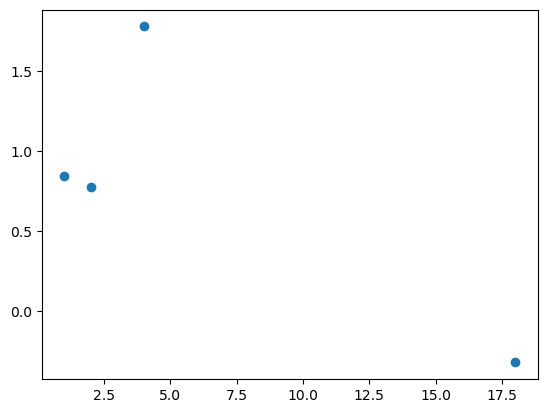

In [28]:
v = torch.randn_like(t)
plt.scatter(t, v);

We do the same thing, take the difference of `t` to its `mean` 
and `v` to its `mean`, and take the `mean` of that.
That's a very small number.
Covariance is basically telling us how related are these two tensors.

In [29]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-3.88)

We can think of variance as being covariance with itself.
We can change this mathematical version to this easier to calculate version which gives the same answer.

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [30]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-3.88)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [31]:
cov / (t.std() * v.std())

tensor(-0.57)

It's just a scaled version of the same thing.

In [32]:
x.std()

tensor(0.85)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [33]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.04), tensor(0.88))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

At the beginning our Vector has a mean of about zero and a standard deviation about one,
because that's what we asked for earlier (via `randn()`)
Let's create some random numbers and we can confirm they have a mean of
about zero and a standard deviation of about one.
If we chose weights for `a` that'd have a mean of zero we can
compute the standard deviation quite easily.
Let's do that a hundred times let's try creating X and creating something to multiply it by (a).
We do the matrix multiplication and we're going to get the mean and mean of the squares.
That is very close to our Matrix.
As long as the elements in `a` and `x` are independent (which they are because they're random),
then we're going to end up with a mean of zero and a standard deviation of one for these products.

In [34]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.0930471070855856, 102.9146979522705)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [35]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(-0.002986055881790071, 0.9694275963147889)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

### Background

The problem is that it doesn't work for us because we use
rectified linear units (not something that Xavier looked at).
Let's create a 200 by 100 matrix and a 200 vector.

In [36]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [37]:
from math import sqrt

Let's create a couple of weight matrices two weight matrices and two bias vectors.
We've got some input data x's and y's and we've got some weight
matrices and bias vectors so 

In [38]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

Let's create a linear layer function and let's start going through a little neural net.
Imagining this is the forward pass of our neural net.
We're going to apply our linear layer to the axes with our first set of
weights and our first set of biases.

In [39]:
def lin(x, w, b): return x @ w + b

In [40]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(0.02), tensor(0.98))

The mean and standard deviation is about zero and about one.
(because we have 100 inputs and we divided it by square root 100 just like Xavier told us to)
Our second one has 50 inputs and we divide by square root of 50 and so this
all ought to work right.

But now we're going to mess everything up by doing RELU.

In [41]:
def relu(x): return x.clamp_min(0.)

After we do a RELU we don't have as zero mean or a one standard deviation anymore.

In [42]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.40), tensor(0.58))

So if we create a deep neural network with global initialization but with a RELU.
It's all gone to zero and you can see why right after a matrix
multiply and a value our means and variances are going down (because a RELU squishes it).

In [43]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

So let's try it.
We've got 100 inputs, so we multiply it by root 2 over 100 and
we get  non-zero numbers, even after going through 50 layers of depth.
This is called Kaiming or He initialization. 

In [44]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.00, 0.00, 0.07, 0.00],
        [0.00, 0.00, 0.00, 0.01, 0.00],
        [0.07, 0.00, 0.00, 0.06, 0.00],
        [0.00, 0.00, 0.00, 0.15, 0.00],
        [0.02, 0.00, 0.00, 0.00, 0.00]])

### Applying an init function

Now that we know what initialization function to use for a deep neural network with a relu
activation function the trick is to use a method called `apply` which all `nn.modules` have.
So if we grab our model we can `apply` any function.
For example, let's apply the function print the name of the type.
It's going through and it's printing out all of the modules that are inside our model.

In [45]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


Notice that our model um has modules inside modules.
it's a conv in a sequential in a sequential.
But model did apply through all of them regardless of their depth.

In [89]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

So we can apply an init function which simply does
multiple random numbers normally distributed with random numbers
times square root of 2 over the number of inputs.
That is what `init.kaiming_normal_()` does.
`_` at the end of a Pytorch method name means that it changes something in place.
So it will modify this weight matrix `m.weight` that was initialized with normally distributed random numbers 
based on root of 2 divided by the number of inputs.

We can't do that to a sequential layer or a flattened layer.
So we check that the module is a `conv`.

In [46]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

and then  we can `model.apply` the `init_weights` function

In [47]:
model.apply(init_weights);

When we create our learner `MomentumLearner()`.

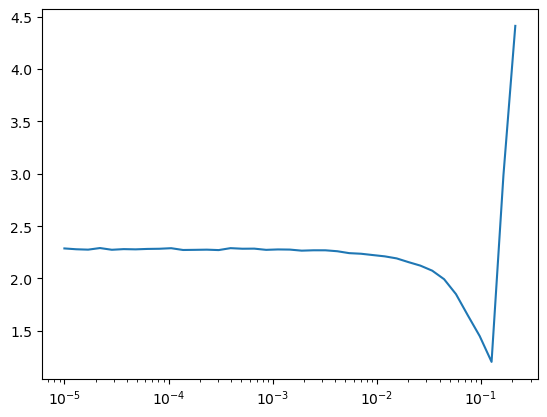

In [48]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

After we get the model we `apply(init_weights)`, which 
also returns the model so we can use it with the initialization applied.

In [49]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.592,1.203,0,train
0.779,0.582,0,eval
0.819,0.490,1,train
0.830,0.462,1,eval
0.844,0.425,2,train
0.841,0.436,2,eval


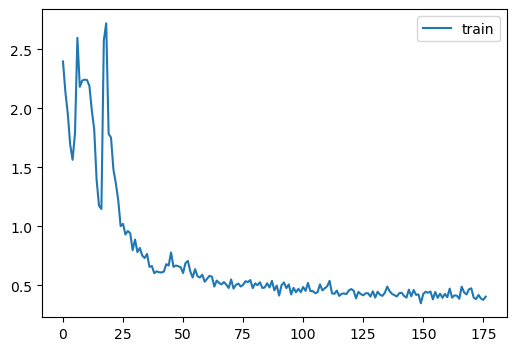

In [50]:
learn.fit(3)

Still not able to train well ...it's not great but it is actually starting to train.

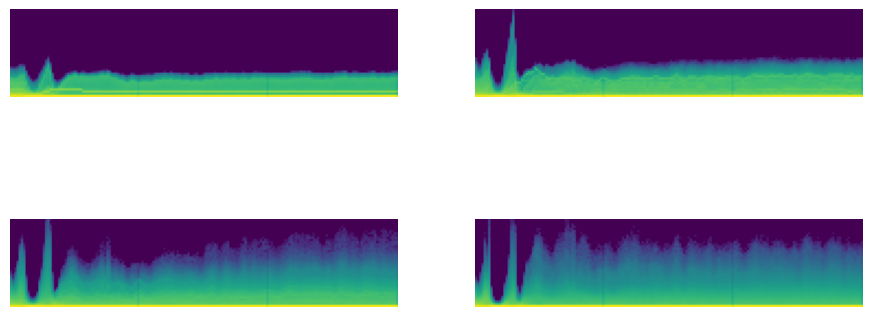

In [51]:
astats.color_dim()

we're getting these spikes...

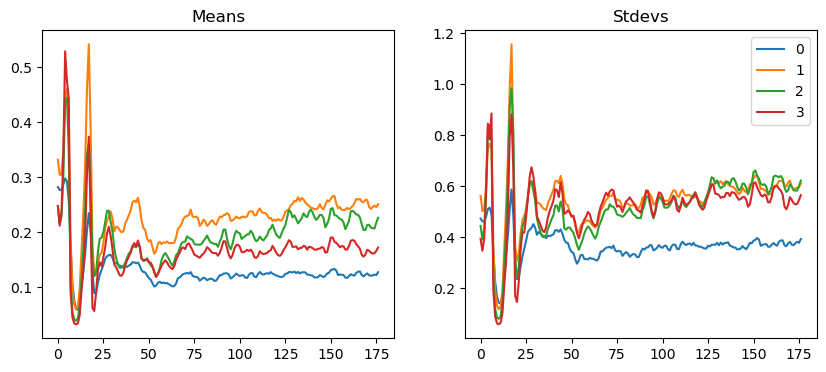

In [52]:
astats.plot_stats()

why is that?
Because we forgot something critical.
Even when we had the correctly normalized metrics that we're multiplying by
well you also have to have a correctly normalized input Matrix.
And we never did anything to normalize our inputs.

## Input normalization

Lets get the first xb minibatch mean (.28) and standard deviation (0.35). 
We didn't even start with a zero-one input.
We need to modify our inputs so they have a mean of zero and a standard deviation of one.

In [53]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.28), tensor(0.35))

Let's create a `BatchTransformCB(Callback)`.
We're going to pass in a function that's going to transform every batch.
In the `before_batch` we will set the batch to be equal to the function applied to the batch.
Note we don't need `self.learn.batch` on the right, 
(because it's one of the four things that we proxy down to the learner automatically)
but we do need it on the left hand side because it's only in the `getatrr`. 
We just leave it the same on both sides to avoid confusions.

In [54]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

Let's create a function `_norm` that subtracts the mean and divides by the standard deviation.
A batch has an X and a Y.
It's the X part where we subtract the mean and divide by the standard deviation.
The new batch will be the normalized X and the same Y as before.

Let's create an instance of the normalization of the batch transform callback 
which is going to do the normalization function `norm`, 
so we can pass it as an additional callback to our learner.

In [55]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.687,0.931,0,train
0.827,0.460,0,eval
0.851,0.406,1,train
0.844,0.406,1,eval
0.867,0.359,2,train
0.859,0.381,2,eval


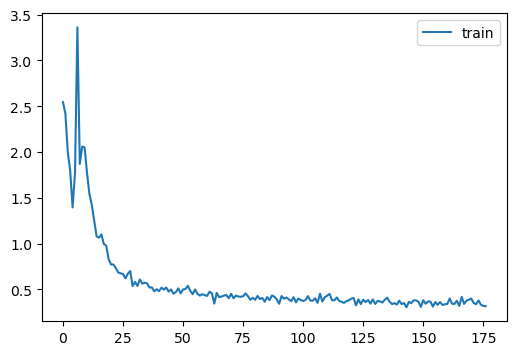

In [56]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

Now that's looking a lot better.
We had to check that our input Matrix was 0 1.
All our weight matrices were 0 1.
Then (without any tricks) it was able to train, and improved accuracy.

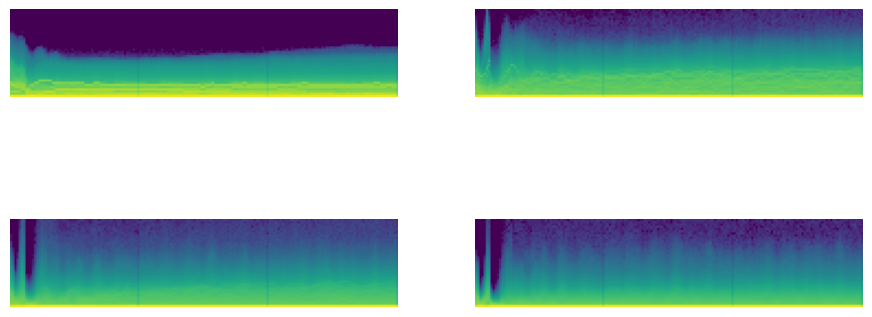

In [57]:
astats.color_dim()

If we look at the color dim and stats it looks beautiful.
It's still not, there's some Randomness, and we've got like seven or eight layers...
That Randomness you go through the layers by the last one it still gets a bit ugly 
you can kind of see it bouncing around.
We can see that also in the means and standard deviations.
There are other reasons why this is happening (we'll see in a moment).
But this is the first time we've got a somewhat deep convolutional model to train.

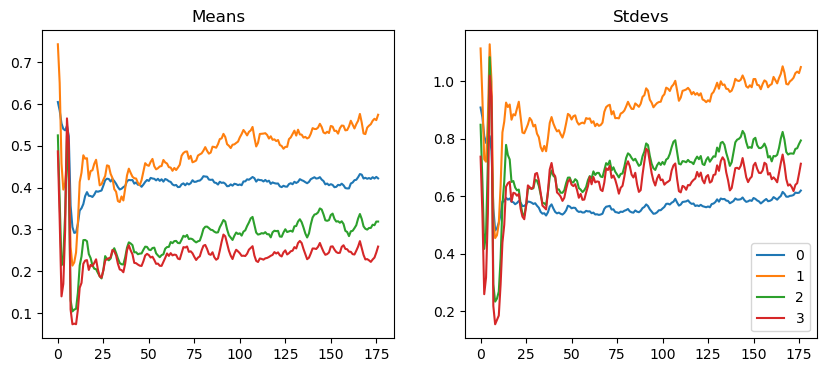

In [58]:
astats.plot_stats()

Milestone: We have created, from scratch, in a sequence of 11 notebooks a real convolutional neural network that is training properly.

We don't have to use a callback for this.
Alternatively we could modify the input data with a `.with_transform` method from the
hugging face data sets Library.
We could modify our transform to just subtract the mean and divide
by the standard deviation and then recreate our data loaders.

In [59]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

If we now get a batch and check it it's got zero mean 
and the standard deviation of one.
so we could also do it this way.

In general, for stuff that needs to dynamically modify the batch you can often do it either
in your data processing code or you can do it in a callback.
Both work well and you can see whichever one works best.

In [60]:
xb.mean(),xb.std()

(tensor(0.), tensor(1.))

## General ReLU

It's training, but after all we did, looking at the `plot_stats`,
we still don't have a mean of zero and a standard deviation of one,
even from the start.
Why?
The problem is that we were putting our data through a RELU
and our activation stats are looking at the output of those RELU
blocks because that's kind of the end of each.
Since the RELU removes all of the negative numbers
it's impossible for the output of a RELU to have a mean of zero 
(unless every single number is zero).
RELU seems to be fundamentally incompatible with the idea of a correctly calibrated 
bunch of layers in a neural net.

Idea: Lets take a normal RELU and have the ability to subtract something from it.
We take the result of our RELU and subtract, `-= self.sub`.  
This will subtract something from our RELU, and will allow us to pull the whole thing down, 
so that the bottom of our value is underneath the x-axis and it has negatives.
That would allow us to have a mean of zero.
Let's also do a leaky RELU, where we not have the negative truncated,
but instead let's just have those negative numbers decreased by some constant amount.

In [61]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

Lets see what that looks like, using `plot_func()` for plotting a function.

In [62]:
#| export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

`GeneralRelu`, is where we do a leaky RELU, so it's not flat under zero,
but instead just less less sloped, and we also substract something from it.

Let's plot `generalRELU` with a leakiness of 0.1 (so there's a 0.1 slope underneath the 0),
and we'll subtract 0.4.

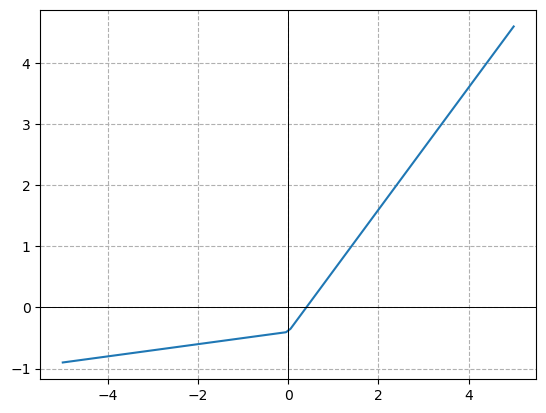

In [63]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

Above zero it's just a normal Y equals X line,  but it's been pushed down by 0.4.
And when it's less than zero it's not flat anymore but it's got a slope of one-tenth.
If we find the right amount to subtract for each amount of leakiness we can make a mean of zero.
JH found a particular combination (.1 and .4) which gives us a mean of zero or thereabouts.

Let's create a new convolution function where we can change what activation function `act` is used.
That gives us the ability to change the activation functions in our neural Nets.

In [64]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

Let's change `get_model` to allow it to take an activation function `act`
which is passed into the layers.
Let's also make it easy to change the number of filters,
so we're going to pass in a list of the number of filters in each layer, `nfs`,
and we will default it to the numbers in each layer that we've discussed `[1,8,16,32,64]`.

We're going to go through a list comprehension creating a convolution 
from the previous number of filters to the next number of filters.
And we'll pop that all into a `nn.Sequential` along with a `nn.flatten` at the end.

In [65]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

Kaiming initialization only applies to layers that have a RELU activation function.
We don't have RELU, we have leaky RELU. 
Subtracting a bit from it doesn't change things, but the fact that it is leaky does.
<br>
Pytorch's `Kaiming_normal` has an adjustment for leaky RELU.
If we pass into the `Kaiming_normal_` initialization our leaky value `a` 
then we get the correct initialization for a leaky RELU.
We need to change and it waits now to pass in the leakiness.

In [66]:
#| export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

The activation function is `GeneralRelu` with a leak of 0.1 and a subtract of 0.4.
We use `partial` to create a function that has those built-in parameters.
`ActivationStats` we update to look for GeneralRelu.
For `init_weights` we have a partial with `leaky=0.1`, and we call that `iw`.


In [67]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

We get our model using that new `act_gr` function and that new `iw`. 

In [68]:
model = get_model(act_gr).apply(iw)

We fit that and we're up to a accuracy of 87%.

accuracy,loss,epoch,train
0.766,0.667,0,train
0.844,0.429,0,eval
0.864,0.373,1,train
0.861,0.386,1,eval
0.879,0.331,2,train
0.871,0.363,2,eval


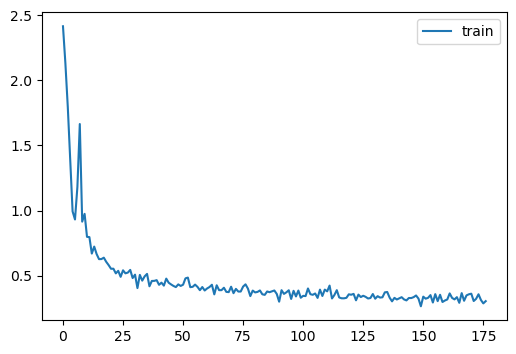

In [69]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

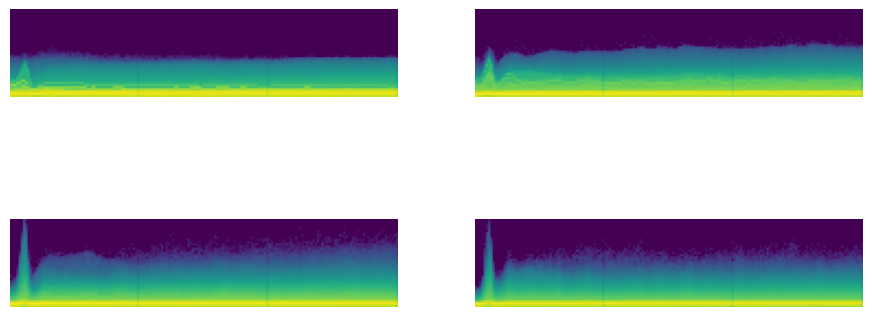

In [70]:
astats.color_dim()

We still got a little bit of a spike but it's almost smooth and flat.

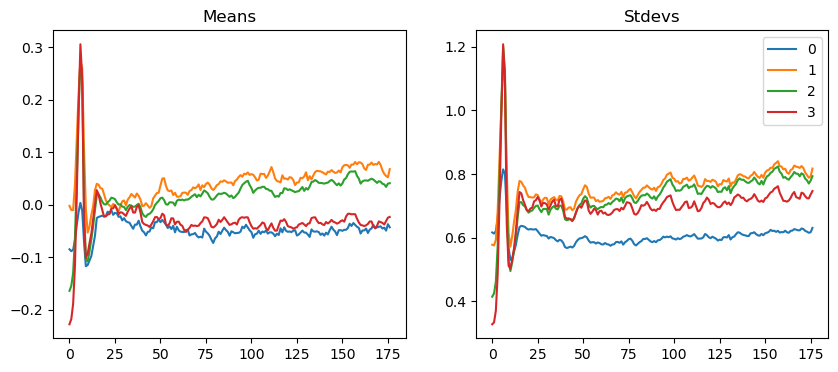

In [71]:
astats.plot_stats()

Our mean is starting at about zero, standard deviation is still a bit low,
but it's coming up around one, generally around 0.8.

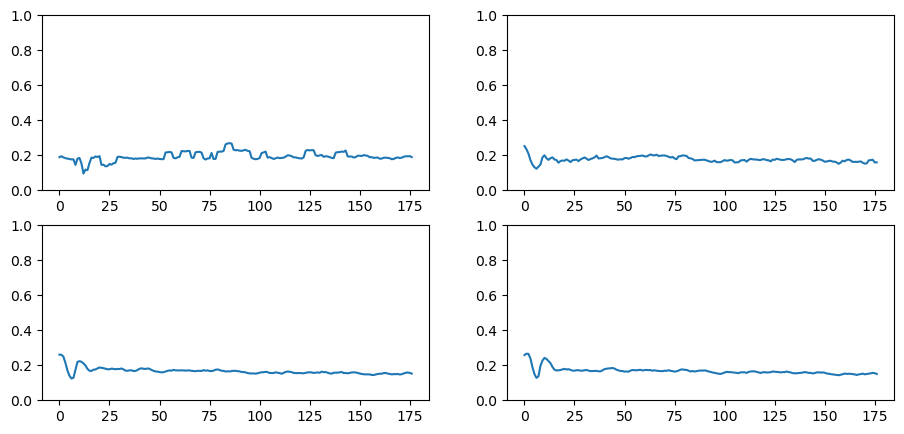

In [72]:
astats.dead_chart()

The percentage of dead units in each layer is very small
so finally very nice looking training graphs.

We had to invent our own activation function to make this work.
Few people care about this, which is critical and not 
mathematically difficult to make it work,
and it's not computationally difficult to see whether it's working.
Other Frameworks don't let you plot these kinds of things.
So people don't know that they've messed up their initialization.

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces *Layer-wise Sequential Unit-Variance* (*LSUV*).

This paper showed that there's a general way of initializing any neural network correctly regardless of what activation functions.
Simple idea: create a model, initialize it however you like, then go through a single batch of data, 
look at the first layer see what the mean and standard deviation is.
If the standard deviation is too big divide the weight matrix by a bit.
If the means is too high subtract a bit off the weight Matrix.
Do that repeatedly for the first layer until you get the correct mean and standard deviation.
Then go to each other layer and do the same thing.

We can do that using hooks.
Lets create a `_lsuv_stats` that will grab the mean and the standard deviation of the activations of a layer.
And we will create a `Hook` `h` with that function. 
After we've run that hook to find out the mean and standard deviation of the layer,
we will go through and run the model, get the standard deviation and mean, 
see if the standard deviation is not one, see if the mean is not zero.
We will subtract the mean from the bias, and we will divide the weight matrix by the standard deviation.
And we will keep doing that until we get a standard deviation of one and a mean of zero.


In [73]:
#export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

By making that a hook, we will grab all the relus and all the convs.

In [74]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

Once we've got all the values and all the convs, we can use zip
to take a bunch of lists and create a list of the items:
the first items, the second items, the third items and so forth.
If I go through the zip of values and convs and just print them.
it prints out their relu and the first conv,
the second relu and the second conv, etc.
<mark> We use zip a lot so it's important.</mark>

In [75]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


So we could go through the relus and the convs and call `lsuv_init` passing in those
relus and convs.
We're going to do that on the the batch, and we need to put the batch on the correct device for our model.

In [76]:
for ms in zip(relus,convs): lsuv_init(*ms, xb.to(def_device))

Now have it ran almost instantly, it's made all the biases and weights correct, give us 0 1.
Now we train, and it works, and we didn't do any initialization 
other than call `lsuv_init`.
This time we've got an accuracy of 0.86, previously it's 0.87 so
pretty much the same thing close enough.


accuracy,loss,epoch,train
0.776,0.636,0,train
0.845,0.435,0,eval
0.861,0.375,1,train
0.857,0.403,1,eval
0.876,0.335,2,train
0.862,0.387,2,eval


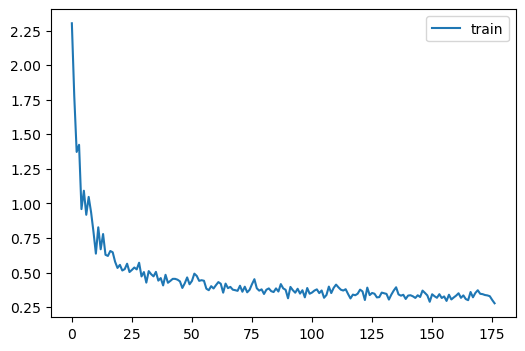

In [77]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

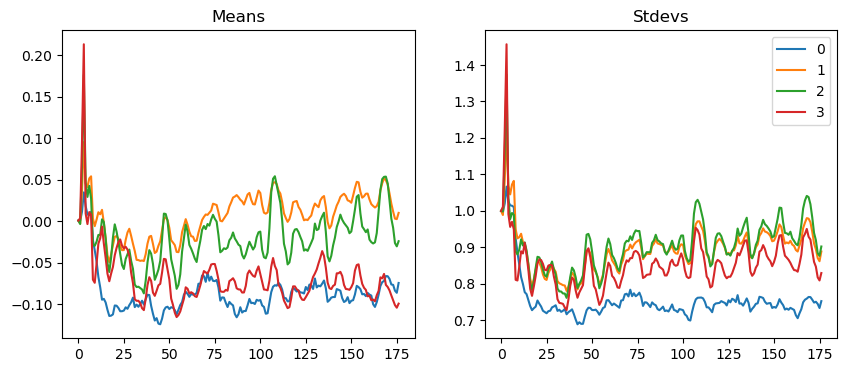

In [78]:
astats.plot_stats()

If we want to see that happening, we could say print h.mean, h.std before and after. 
So it starts at the first layer, at a mean of point negative 0.13 and a variance of 0.46
and it kept doing the Divide Subtract,
until eventually it got to minus zero standard deviation of one,
and then it went to the next layer and it kept going until that was 0 1,
until all of the layers had a mean of zero and a standard deviation of one.

`lsuv` is mathematically convenient, as we don't have to spend any time thinking about 
a new activation function or we're using some activation function where nobody seems 
to have figured out the corrected initialization for it.
Just use `lsuv`.
It did require a little bit more fiddling with hooks to get it to work.
We haven't put this into a callback.
It might be a good idea homework to see if we can come up with a callback 
that does lsuv initialization.
Careful because if we ran fit multiple times it would initialize it each time.

## Batch Normalization

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with [layer normalization](https://arxiv.org/abs/1607.06450), a simpler technique.

In [79]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [80]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [81]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.772,0.646,0,train
0.848,0.425,0,eval
0.864,0.372,1,train
0.862,0.378,1,eval
0.881,0.328,2,train
0.872,0.349,2,eval


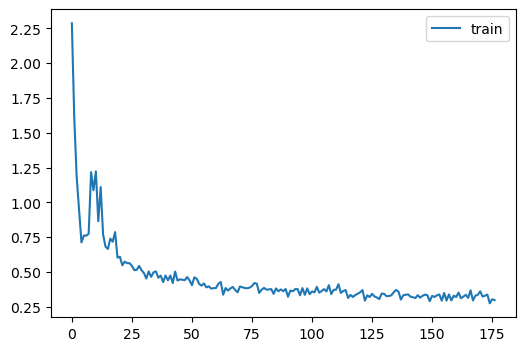

In [82]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [83]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.787,0.582,0,train
0.829,0.481,0,eval
0.872,0.349,1,train
0.864,0.379,1,eval
0.886,0.309,2,train
0.877,0.343,2,eval


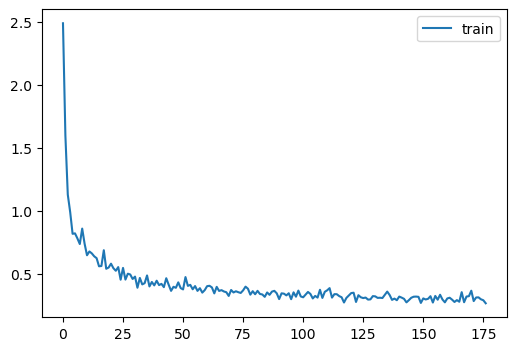

In [84]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![Various norms](images/norms.png)

## Towards 90%...

In [85]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.836,0.453,0,train
0.855,0.406,0,eval
0.880,0.325,1,train
0.872,0.362,1,eval
0.891,0.293,2,train
0.873,0.362,2,eval


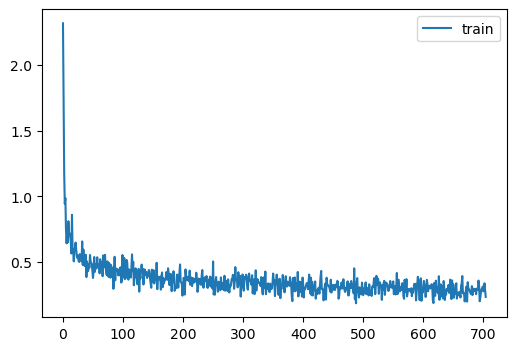

In [86]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.913,0.236,0,train
0.894,0.295,0,eval
0.918,0.223,1,train
0.895,0.293,1,eval


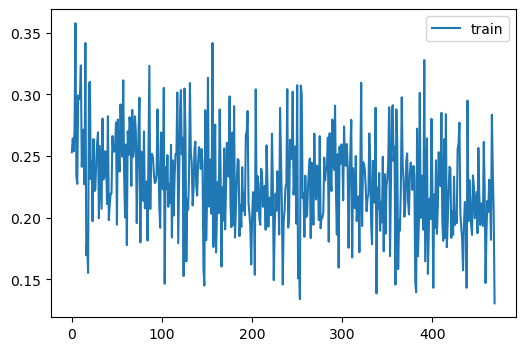

In [87]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [88]:
import nbdev; nbdev.nbdev_export()